In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Colab Notebooks/flickr'

captions.txt  Files  Images


In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = 'drive/MyDrive/Colab Notebooks/flickr'
WORKING_DIR = 'drive/MyDrive/Colab Notebooks/flickr/Files'
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
#Extracting Features
features = {}
directory = 'drive/MyDrive/Colab Notebooks/flickr/Images'

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name #Loading Image
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image) #Converting Image
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # Reshaping Data for Model
    image = preprocess_input(image) #Preprocessing Images
    feature = model.predict(image, verbose=0) #Extracting Features from Images
    image_id = img_name.split('.')[0]
    features[image_id] = feature #Storing Features

In [ ]:
#pickle.dump(features, open('drive/MyDrive/Colab Notebooks/flickr/Files/features.pkl', 'wb'))

In [4]:
with open('drive/MyDrive/Colab Notebooks/flickr/Files/features.pkl', 'rb') as f:
    features = pickle.load(f)

In [5]:
with open('drive/MyDrive/Colab Notebooks/flickr/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
mapping = {} #Mapping Images to Captions
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',') #Splitting Captions
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0] # removing extension from image ID
    caption = " ".join(caption) # converting caption string

    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption) # storing captions

len(mapping)

  0%|          | 0/40456 [00:00<?, ?it/s]

8091

In [7]:
#Preprocessing Text Data
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [8]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
# preprocess the text
clean(mapping)

In [10]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [12]:
len(all_captions)

40455

In [13]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
# tokenize the text - converts sentences into words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [15]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
# create data generator to get data in batch (avoids session crash) - creates a big vector 
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

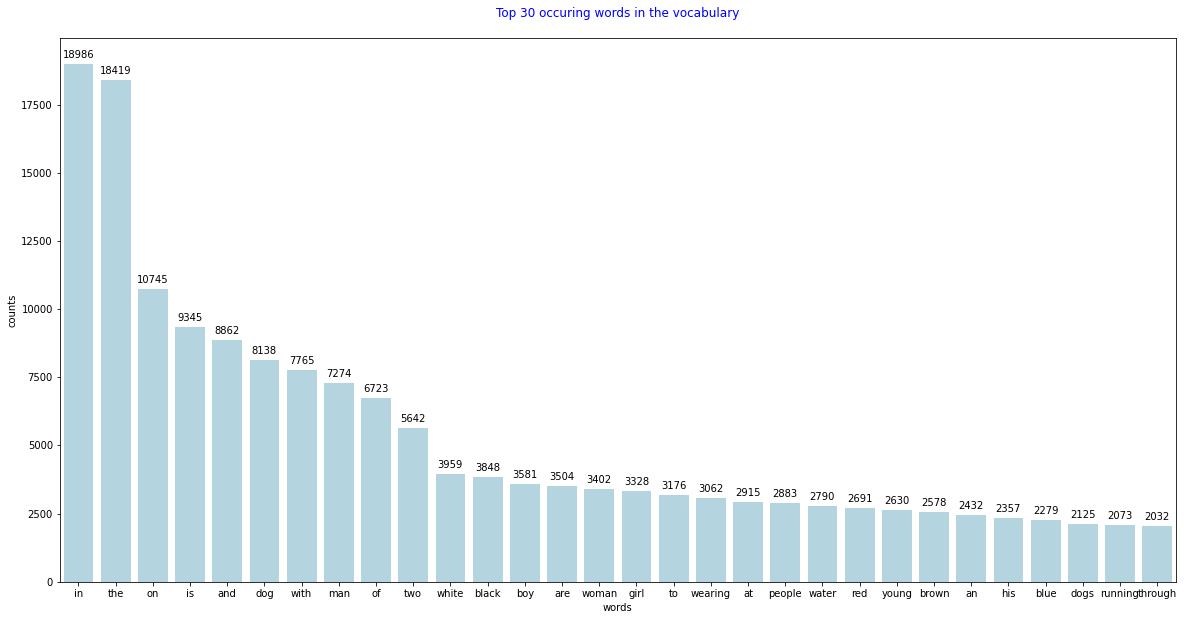

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tokenizer_df = pd.DataFrame([tokenizer.word_counts]).transpose().reset_index()

top30words = tokenizer_df.sort_values(by=0,ascending=False).head(32).reset_index(drop=True).rename(columns={"index":"words",0:"counts"})

plt.figure(figsize=(20,10))
plt.title('Top 30 occuring words in the vocabulary\n',color='b')
plt.xlabel('Words')
plt.ylabel('Count')
plot=sns.barplot(x=top30words.words[2:],y=top30words.counts[2:], color='lightblue')

for p in plot.patches:
    plot.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

In [19]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
loss = []
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    x = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss.append(x.history['loss'][0])

227/227 [==============================] - 1130s 5s/step - loss: 2.1216


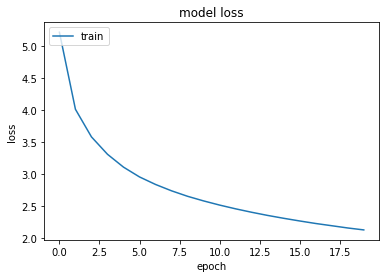

In [ ]:
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#model.save('drive/MyDrive/Colab Notebooks/flickr/Files/new_optimized_model_20.h5')

In [20]:
#Run this to load model
model.load_weights('drive/MyDrive/Colab Notebooks/flickr/Files/new_optimized_model_20.h5')

In [21]:
#Generating Captions
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [22]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.513976
BLEU-2: 0.292735


In [23]:
from PIL import Image
import matplotlib.pyplot as plt
def predict_new_image(img_path):
  image = load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  image = img_to_array(image) #Converting Image
  image = image.reshape((1, 224, 224, 3)) # Reshaping Data for Model
  image = preprocess_input(image) #Preprocessing Images
  model_init = VGG16()
  model_init = Model(inputs=model_init.inputs, outputs=model_init.layers[-2].output)
  feature = model_init.predict(image, verbose=0)
  y_pred = predict_caption(model, feature, tokenizer, max_length)
  print('-----------------------------Predicted-----------------------------')
  print(y_pred[8:-7])
  return y_pred[8:-7]

-----------------------------Predicted-----------------------------
 brown dog with yellow collar runs through field


' brown dog with yellow collar runs through field'

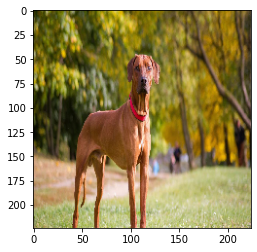

In [25]:
predict_new_image('/content/dog.jpg')

In [26]:
!pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


-----------------------------Predicted-----------------------------
 mountain biker riding on dirt bike


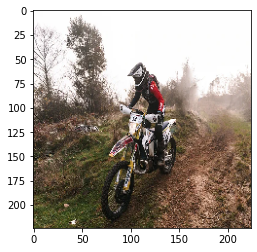

In [27]:
# Import the required module for text to speech conversion
from gtts import gTTS
from IPython import display
# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
myobj = gTTS(text=predict_new_image('/content/dirt.jpg'), lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
audio_file_name = "Predicted_text.mp3"
  
# Playing the converted file
myobj.save(audio_file_name)

display.display(display.Audio(audio_file_name, rate=None,autoplay=False)) # Playing the saved file